***WORKSHOP 2 Object detection using web camera***                          
***Name: K.SRISARAN KARTHIK***                      
***Reg No: 212224230275***   

In [ ]:
import os
for f in ["yolov4.cfg", "yolov4.weights", "coco.names"]:
    print(f, "->", os.path.exists(f))


yolov4.cfg -> True
yolov4.weights -> True
coco.names -> True


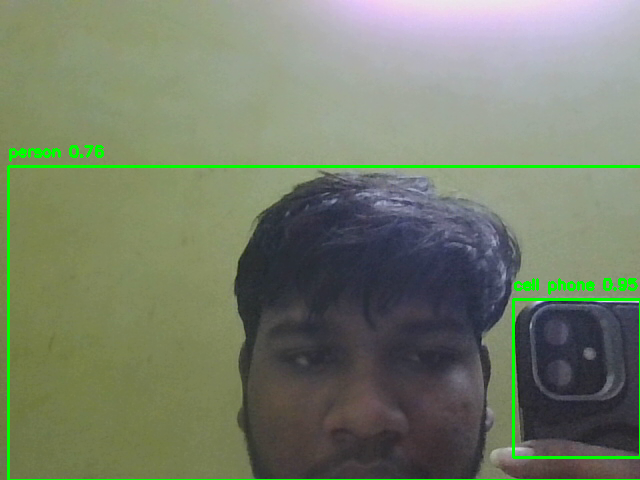

In [ ]:
import cv2
import numpy as np
from IPython.display import display, clear_output
from PIL import Image

# --- Load network and labels ---
net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")

with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

# --- Open webcam ---
# On Windows, CAP_DSHOW often fixes "can't open camera" issues.
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

if not cap.isOpened():
    raise RuntimeError("Could not open webcam. If on Windows, ensure camera permission is allowed for Python/Jupyter.")

try:
    while True:
        ok, frame = cap.read()
        if not ok or frame is None:
            print("Frame grab failed; stopping.")
            break

        (H, W) = frame.shape[:2]

        # YOLO input
        blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        outputs = net.forward(output_layers)

        # Collect detections
        boxes, confidences, class_ids = [], [], []
        for out in outputs:
            for det in out:
                scores = det[5:]
                class_id = int(np.argmax(scores))
                conf = float(scores[class_id])
                if conf > 0.5:
                    cx, cy, w, h = det[0:4]
                    x = int(cx * W - (w * W) / 2)
                    y = int(cy * H - (h * H) / 2)
                    boxes.append([x, y, int(w * W), int(h * H)])
                    confidences.append(conf)
                    class_ids.append(class_id)

        idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

        # Draw
        if len(idxs) > 0:
            for i in idxs.flatten():
                x, y, w, h = boxes[i]
                label = f"{classes[class_ids[i]]} {confidences[i]:.2f}"
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
                cv2.putText(frame, label, (x, max(0, y-10)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

        # Show inline in notebook
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)
        display(Image.fromarray(rgb))
except KeyboardInterrupt:
    # Stop with the Jupyter "Stop" button or Ctrl+M, I then I
    pass
finally:
    cap.release()
    cv2.destroyAllWindows()
